### This is Assignment2 Part2 for EE214 Machine Learning Basics and Practices.
Euiseok Han, 20200690\
Date: 052125

I utilized the given skeleton code.

In [511]:
!pip install ucimlrepo #This installs the UCIML library to import the dataset

In [512]:
# ==========================================
# EE214 Assignment 2 Clustering Skeleton
# ==========================================
# Code skeleton for Task 2. You may change it as you deem necessary.

# ---------- 0. Imports ----------
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo  # one line UCI fetch

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer # for handling missing values
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE


# For AutoEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

seed_global=42
# fixing seed
def set_seed(seed=seed_global):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    g = torch.Generator()
    g.manual_seed(42)

    return g    

In [513]:
# ---------- 1. Data Loading ----------
derm = fetch_ucirepo(name="Dermatology")  # TODO: cache locally if slow

X_raw = derm.data.features.to_numpy()  # 34 features (no labels)
X_unknown = pd.read_csv("unknown_dataset.csv").to_numpy()  # 5452 × 10 PCA
y_true = derm.data.targets.to_numpy().astype(int).flatten()  # ground truth, will be used after step 8

#TODO: Filling missing values
# According to the official website of the dataset, some values of ages are missing.
# However, age might irrelevant to the class code.
# Also, since the number of missing values are small compare to the number of samples,
# I just filled the missing values with mean value of other samples.
imputer = SimpleImputer(strategy='mean')
X_filled = imputer.fit_transform(X_raw)

In [514]:
# ---------- 2. Scaling ----------
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X_filled)

minmax_scaler = MinMaxScaler()  # for comparison
X_minmax = minmax_scaler.fit_transform(X_filled)

In [515]:
# ---------- 3. Dimensionality Reduction ----------
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_std)
X_pca_minmax = pca.fit_transform(X_minmax)

# Verify PCA output shape
print('PCA after standard scaling output shape:', X_pca.shape)
print('PCA after minmax scaling output shape:', X_pca_minmax.shape)

PCA after standard scaling output shape: (366, 22)
PCA after minmax scaling output shape: (366, 22)


Number of components in PCA to explain over 95% of the variance: 22

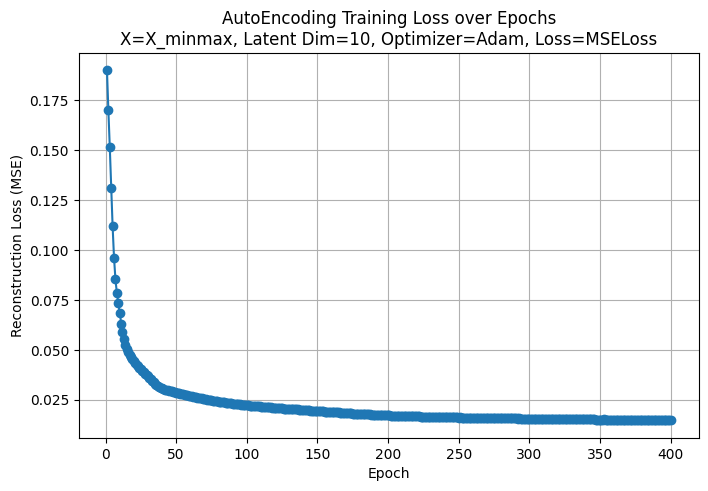

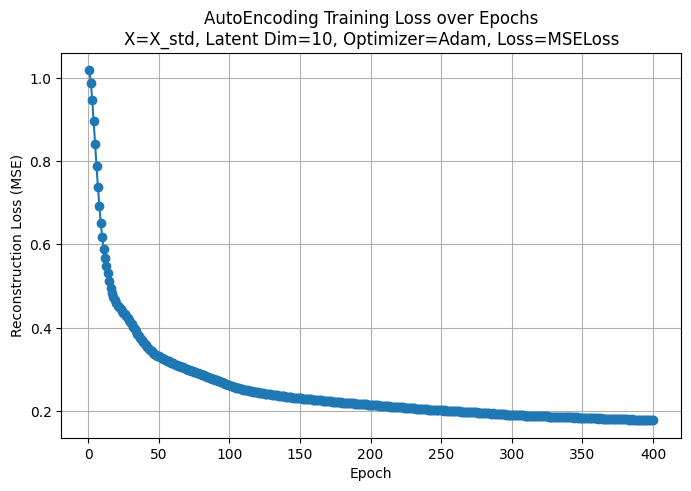

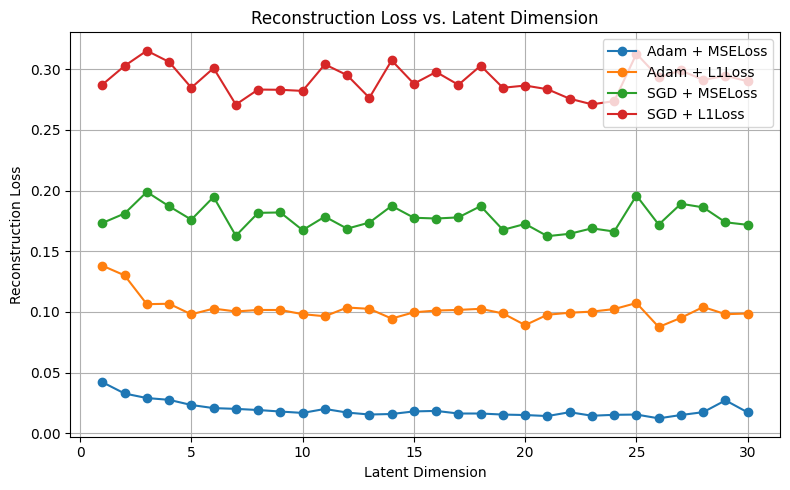

In [516]:
# ---------- AutoEncoder stub ----------
class AE(nn.Module):
    def __init__(self, in_dim, latent_dim=10):
        super().__init__()
        # TODO: define encoder / decoder layers
        # I designed encoder with input_layer(dim=34), hidden_layer(dim=16), and output_layer(dim=latent_dim)
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )
        # Again, I designed decoder with input_layer(dim=latent_dim), hidden_layer(dim=16), and output_layer(dim=34)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, in_dim)
        )

    # pass through a sample into the encoder following by the decoder.
    def forward(self, x):
        # TODO: forward pass
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)

        return reconstructed
    
    def encode(self, x):
        return self.encoder(x)

def train_ae(x_np, latent_dim, epochs, optimizer, criterion, generator):
    """Returns latent representation (np.ndarray)."""
    # TODO: build model, optimizer, loss, training loop

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x_tensor = torch.tensor(x_np, dtype=torch.float32)
    dataset = TensorDataset(x_tensor)
    loader = DataLoader(dataset, batch_size=32, shuffle=True, generator=generator)

    model = AE(in_dim=x_np.shape[1], latent_dim=latent_dim).to(device)
    opt = optimizer(model.parameters(), lr=1e-3)
    cri = criterion()
    epoch_losses = []

    # Train model
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch in loader:
            inputs = batch[0].to(device)
            opt.zero_grad()
            outputs = model(inputs)
            loss = cri(outputs, inputs)
            loss.backward()
            opt.step()
            epoch_loss += loss.item() * inputs.size(0)
        epoch_loss /= len(loader.dataset)
        epoch_losses.append(epoch_loss)

    # 학습 후 latent representation 추출
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.to(device)
        latent = model.encode(x_tensor).cpu().numpy()

    return latent, epoch_losses


# latent_dim = 10
# epochs = 100
# X_ae, loss = train_ae(X_std, latent_dim, epochs)
# -------------------------------------
losses_dict = {}
dims = list(range(1, 31))
optimizers = [optim.Adam, optim.SGD]
criterions = [nn.MSELoss, nn.L1Loss]
g = set_seed(seed_global)

X_ae, epoch_losses = train_ae(X_minmax, latent_dim=10, epochs=400, optimizer=optim.Adam, criterion=nn.MSELoss, generator=g)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
plt.title(f"AutoEncoding Training Loss over Epochs\nX={'X_minmax'}, Latent Dim={'10'}, Optimizer={'Adam'}, Loss={'MSELoss'}")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (MSE)")
plt.grid(True)
plt.show()

X_ae, epoch_losses = train_ae(X_std, latent_dim=10, epochs=400, optimizer=optim.Adam, criterion=nn.MSELoss, generator=g)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
plt.title(f"AutoEncoding Training Loss over Epochs\nX={'X_std'}, Latent Dim={'10'}, Optimizer={'Adam'}, Loss={'MSELoss'}")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (MSE)")
plt.grid(True)
plt.show()

for optimizer in optimizers:
    for criterion in criterions:
        losses = []
        g = set_seed(seed_global)
        for latent_dim in dims:
            X_ae, epoch_losses = train_ae(X_minmax, latent_dim=latent_dim, epochs=150, optimizer=optimizer, criterion=criterion, generator=g)
            losses.append(epoch_losses[-1])
            
        label = f"{optimizer.__name__} + {criterion.__name__}"
        losses_dict[label] = losses

plt.figure(figsize=(8, 5))
for label, losses in losses_dict.items():
    plt.plot(dims, losses, marker='o', label=label)

plt.title('Reconstruction Loss vs. Latent Dimension')
plt.xlabel('Latent Dimension')
plt.ylabel('Reconstruction Loss')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Experiment results show that only 150 epoch is enough to observe efficiency of the training result.\
Comparing four different combinations of optimizers and loss functions, I decided to use Adam optimizer and MSELoss function in the rest of the experiment.\
Also, by applying elbow method to the graph utilizing Adam optimizer and MSELoss function, I selected latent dimension as 10.

{'Raw': {'inertia': [35359.48568187855, 21190.45852923545, 17436.94612307391, 13606.452010752491, 12063.516526116917, 11351.780821423137, 10566.618493090995, 9851.079964005447, 8870.302823500386, 8606.13808786123, 8328.834661132802, 7841.720019551785, 7461.549904426742, 7119.511091429858], 'silhouette': [np.float64(0.48813353916600455), np.float64(0.4129973435659511), np.float64(0.3559088499031583), np.float64(0.31502045890278657), np.float64(0.2692799028972224), np.float64(0.2763500730672854), np.float64(0.24388614328197622), np.float64(0.24602491086374204), np.float64(0.27585325570314356), np.float64(0.2512959229452112), np.float64(0.24384005889044397), np.float64(0.24775226177204968), np.float64(0.2486035163250228), np.float64(0.24449993197160752)]}, 'PCA_std': {'inertia': [10137.980021698171, 6945.500826420468, 6256.398099980257, 6007.4917510332325, 5065.816164314855, 4936.381333772459, 4764.013615844094, 4627.0207016968, 4557.409605463312, 4435.771415476075, 4247.755039223857, 422

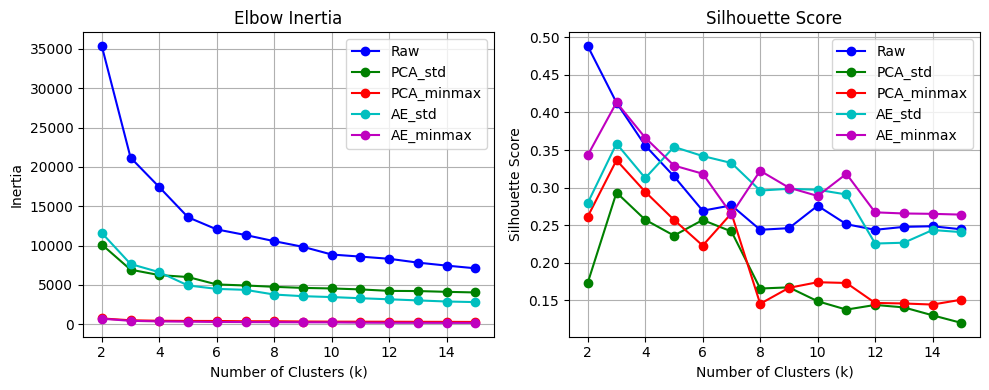

In [517]:
# ---------- 4. Helper: k-Means Elbow & Silhouette ----------
def kmeans_elbow_silhouette_calculator(X, k_range=range(2, 16)):
    inertia, sil = [], []
    for k in k_range:
        # TODO: run KMeans, get inertia and Silhouette scores
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(X)
        inertia.append(model.inertia_)
        sil.append(silhouette_score(X, labels))
    
    return inertia, sil

# From here, we calculate actual elbow inertia and silhouette score
# for three different Xs: X_std(represent raw), X_pca, and X_ae
# Notice that we used X_std rather than X_filled to represent raw data.
k_range = range(2, 16)

g = set_seed(seed_global)
X_ae_minmax, _ = train_ae(X_minmax, latent_dim=10, epochs=150, optimizer=optim.Adam, criterion=nn.MSELoss, generator=g)
X_ae_std, _ = train_ae(X_std, latent_dim=10, epochs=150, optimizer=optim.Adam, criterion=nn.MSELoss, generator=g)

Xs = [X_filled, X_pca, X_pca_minmax, X_ae_std, X_ae_minmax]
labels = ['Raw', 'PCA_std', 'PCA_minmax', 'AE_std', 'AE_minmax']
colors = ['b', 'g', 'r', 'c', 'm']

results = {}
for X, label in zip(Xs, labels):
    inertia, sil = kmeans_elbow_silhouette_calculator(X, k_range)
    results[label] = {'inertia': inertia, 'silhouette': sil}

print(results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for label, color in zip(labels, colors):
    ax1.plot(k_range, results[label]['inertia'], marker='o', label=label, color=color)
    ax2.plot(k_range, results[label]['silhouette'], marker='o', label=label, color=color)

ax1.set_title("Elbow Inertia")
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia")
ax1.grid(True)
ax1.legend(loc='upper right')
# ax1.set_ylim(0, 1000)

ax2.set_title("Silhouette Score")
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Silhouette Score")
ax2.grid(True)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

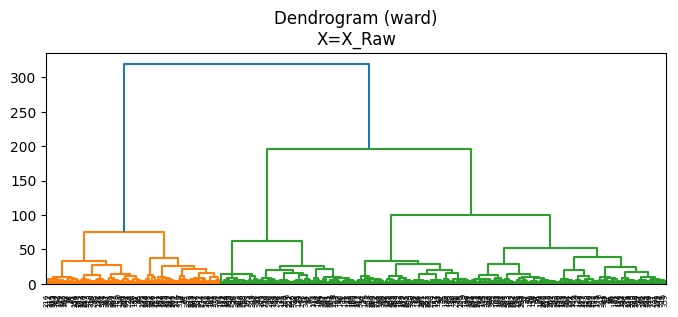

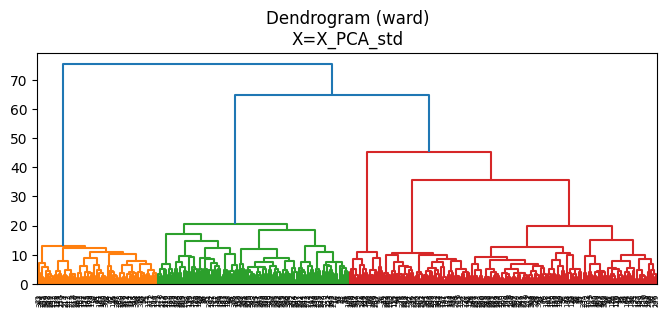

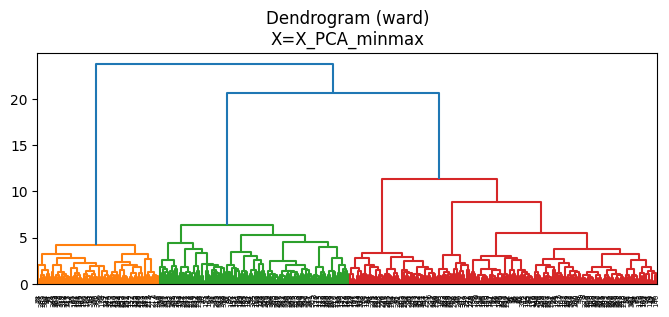

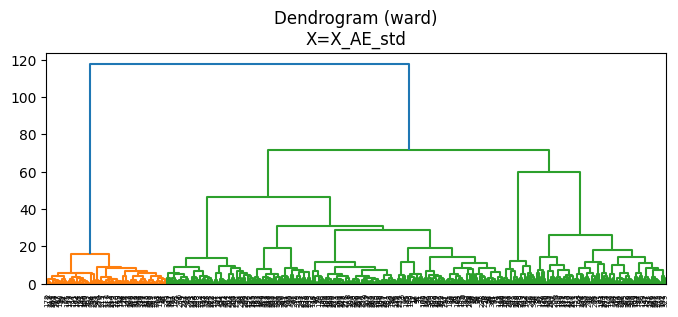

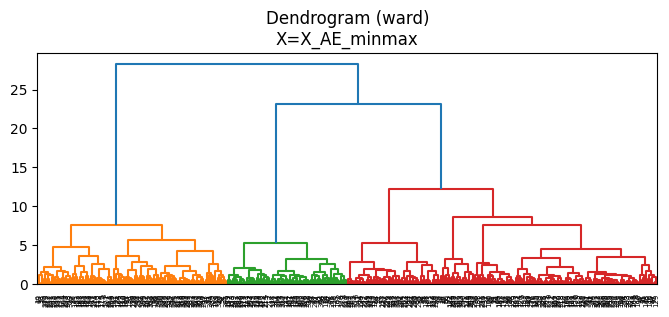

{'Raw': {'silhouette': [np.float64(0.46113929932571135), np.float64(0.4025664728257879), np.float64(0.3075737030975842), np.float64(0.26073102088083683), np.float64(0.25438352274415293), np.float64(0.2321731217099522), np.float64(0.24607201938369636), np.float64(0.24075365528908801), np.float64(0.24087506016675744), np.float64(0.24585963084547421), np.float64(0.23841844312287425), np.float64(0.2399851348287863), np.float64(0.24172892947278174), np.float64(0.2266264725875883)]}, 'PCA_std': {'silhouette': [np.float64(0.27792239635392224), np.float64(0.2925393505040879), np.float64(0.31713467706827436), np.float64(0.2793917147356243), np.float64(0.24183840273630108), np.float64(0.20712101537365427), np.float64(0.20521383144319172), np.float64(0.20973477403656768), np.float64(0.20766217931120426), np.float64(0.21171342932528664), np.float64(0.21177679335986352), np.float64(0.15830867660839149), np.float64(0.14916286004377136), np.float64(0.14552474916324518)]}, 'PCA_minmax': {'silhouette':

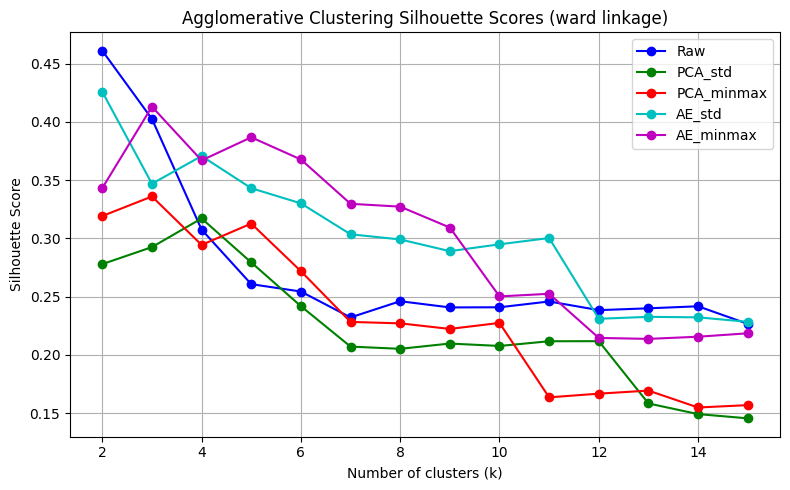

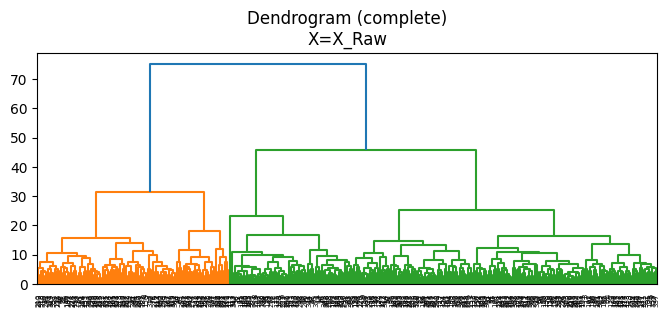

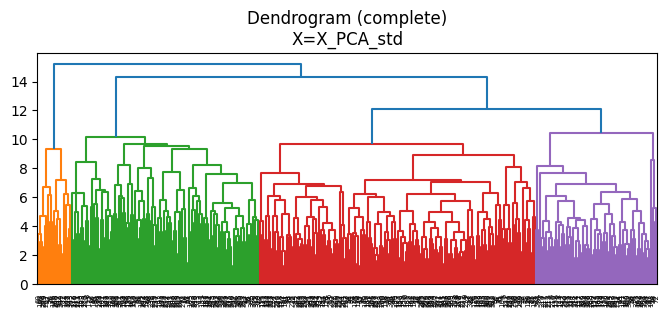

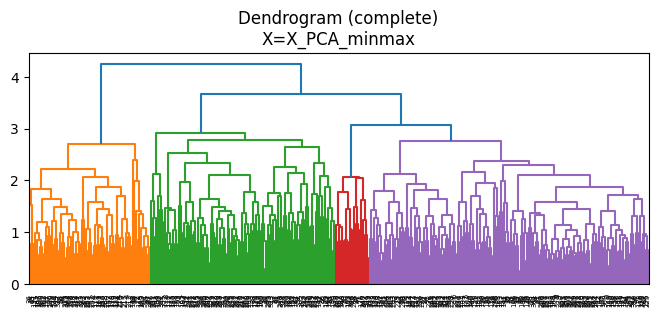

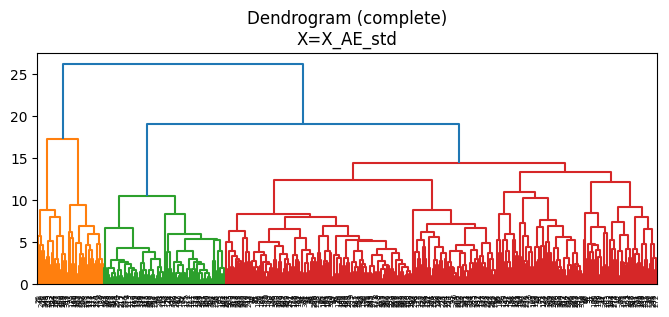

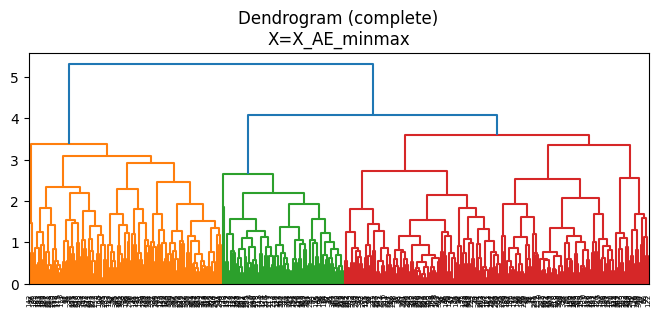

{'Raw': {'silhouette': [np.float64(0.4744902342959425), np.float64(0.4083150747687529), np.float64(0.3391949061046426), np.float64(0.2943998815847337), np.float64(0.2710121490520816), np.float64(0.24800906660958857), np.float64(0.2562610244549367), np.float64(0.21513659574868524), np.float64(0.19831734828245703), np.float64(0.1702136389281873), np.float64(0.17247099000877217), np.float64(0.1683188703743348), np.float64(0.1774707818612384), np.float64(0.18302588701597827)]}, 'PCA_std': {'silhouette': [np.float64(0.2587079936438107), np.float64(0.2562389214467601), np.float64(0.31765613617542937), np.float64(0.28176764198539384), np.float64(0.2384162427007858), np.float64(0.23418524023414672), np.float64(0.21276480059056083), np.float64(0.2079152117649055), np.float64(0.2085406796004127), np.float64(0.19436709583171932), np.float64(0.17448272484704438), np.float64(0.16225344371589673), np.float64(0.16668505877235443), np.float64(0.1689969913686078)]}, 'PCA_minmax': {'silhouette': [np.flo

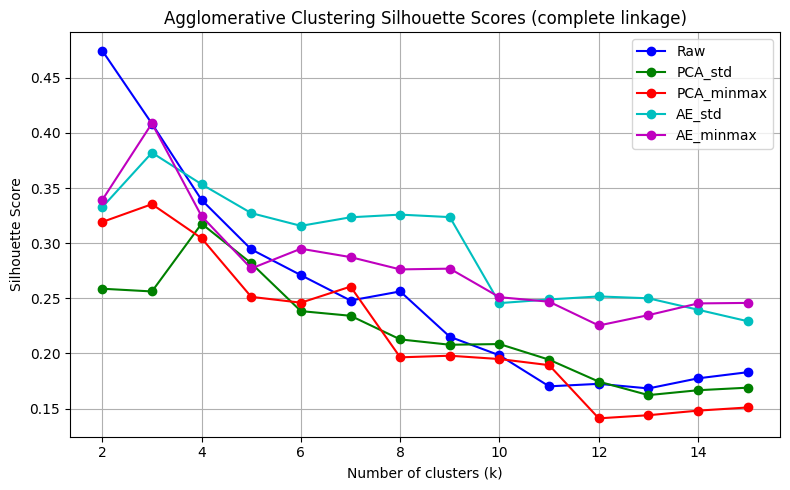

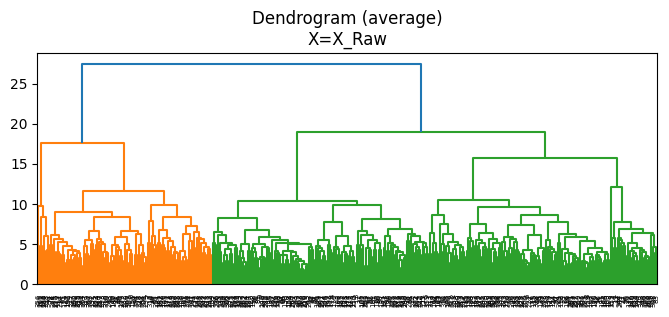

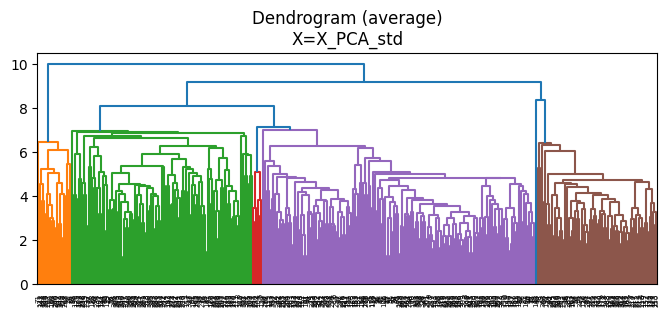

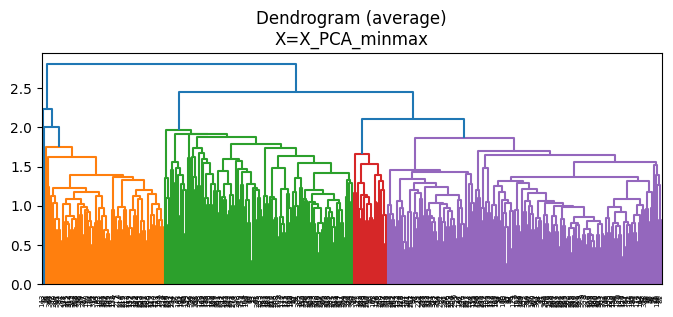

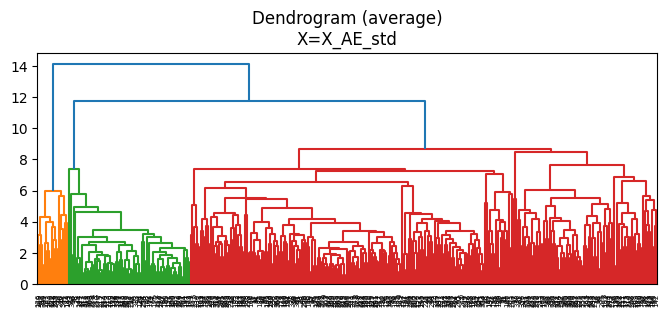

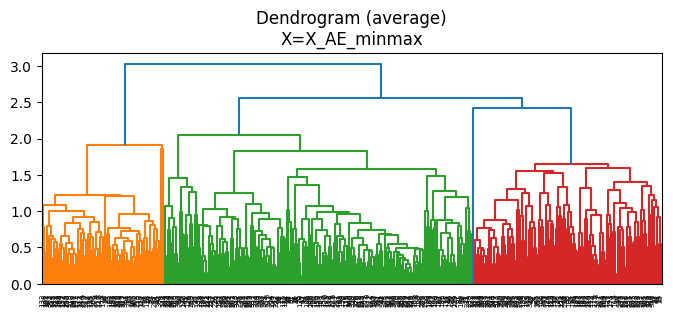

{'Raw': {'silhouette': [np.float64(0.46113929932571135), np.float64(0.3928395484332262), np.float64(0.3559055587363815), np.float64(0.3248048826674595), np.float64(0.31168855608923934), np.float64(0.279110492238528), np.float64(0.2467454112799776), np.float64(0.23055991093082068), np.float64(0.2256229944075234), np.float64(0.24159752663272205), np.float64(0.23794152402156218), np.float64(0.23969670106752095), np.float64(0.24335791668800383), np.float64(0.23524507279633408)]}, 'PCA_std': {'silhouette': [np.float64(0.2587079936438107), np.float64(0.3034054780508893), np.float64(0.2765111694486222), np.float64(0.31011162559918354), np.float64(0.2735963825542503), np.float64(0.25038197335901174), np.float64(0.2115554155552257), np.float64(0.20391595097781023), np.float64(0.2038628041768124), np.float64(0.2003697236066558), np.float64(0.19879115827773391), np.float64(0.2017529008986358), np.float64(0.1906386284460793), np.float64(0.16221347144058318)]}, 'PCA_minmax': {'silhouette': [np.floa

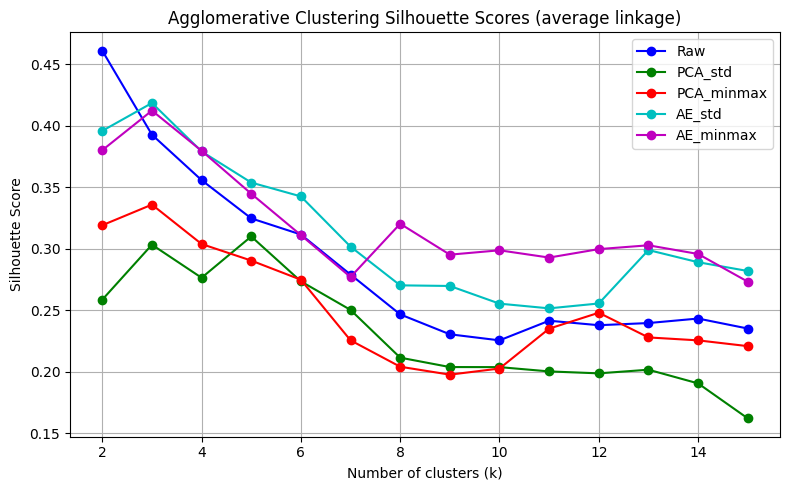

In [518]:
# ---------- 5. Helper: Agglomerative Dendrogram ----------
from scipy.cluster.hierarchy import linkage, dendrogram

def dendro_plot(X, method, label):  # TODO: try other linkage methods
    Z =  linkage(X, method=method) # TODO: get linkage
    plt.figure(figsize=(8, 3))
    # TODO: plot dendrogram
    dendrogram(Z)
    plt.title(f"Dendrogram ({method})\nX=X_{label}")
    plt.show()
    # TODO: compute Silhouette for k=2..15

def agglo_silhouette_calculator(X, method, k_range=range(2, 16)):
    sil = []
    for k in k_range:
        # TODO: run Agglomerative Clustering, get Silhouette scores
        model = AgglomerativeClustering(n_clusters=k, linkage=method)
        labels = model.fit_predict(X)
        sil.append(silhouette_score(X, labels))
    return sil


methods = ['ward', 'complete', 'average']

# X_ae_std, _ = train_ae(X_std, latent_dim=10, epochs=150, optimizer=optim.Adam, criterion=nn.MSELoss, generator=g)
# X_ae_minmax, _ = train_ae(X_minmax, latent_dim=10, epochs=150, optimizer=optim.Adam, criterion=nn.MSELoss, generator=g)

Xs = [X_filled, X_pca, X_pca_minmax, X_ae_std, X_ae_minmax]
labels = ['Raw', 'PCA_std', 'PCA_minmax', 'AE_std', 'AE_minmax']
colors = ['b', 'g', 'r', 'c', 'm']

for method in methods:
    results = {}
    for X, label in zip(Xs, labels):
        dendro_plot(X, method, label)
        sil = agglo_silhouette_calculator(X, method)
        results[label] = {'silhouette': sil}
    
    plt.figure(figsize=(8, 5))
    for label, color in zip(labels, colors):
        plt.plot(range(2, 16), results[label]['silhouette'], marker='o', label=label, color=color)
    print(results)

    plt.title(f'Agglomerative Clustering Silhouette Scores ({method} linkage)')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # print(results)

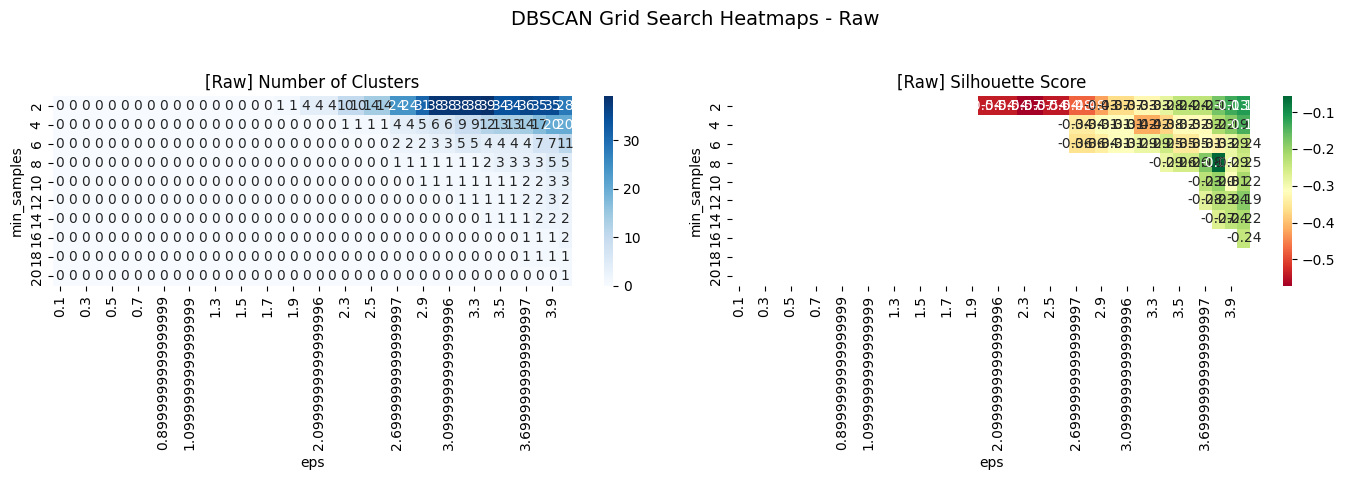

[Raw] Best params: eps=3.8, min_samples=8.0, clusters=3.0, silhouette=-0.0573


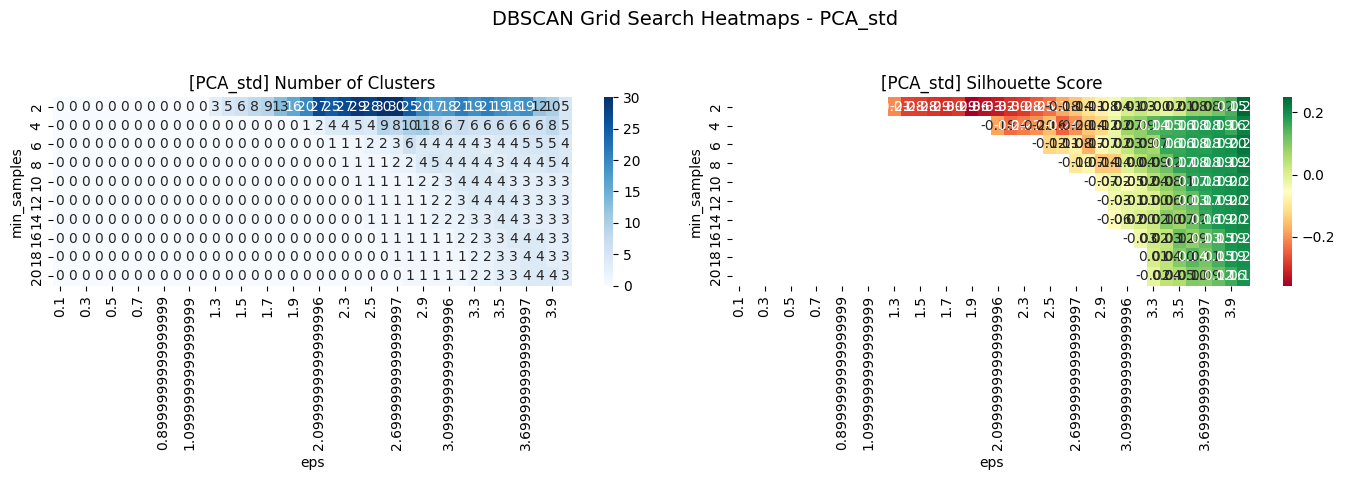

[PCA_std] Best params: eps=4.0, min_samples=2.0, clusters=5.0, silhouette=0.2483


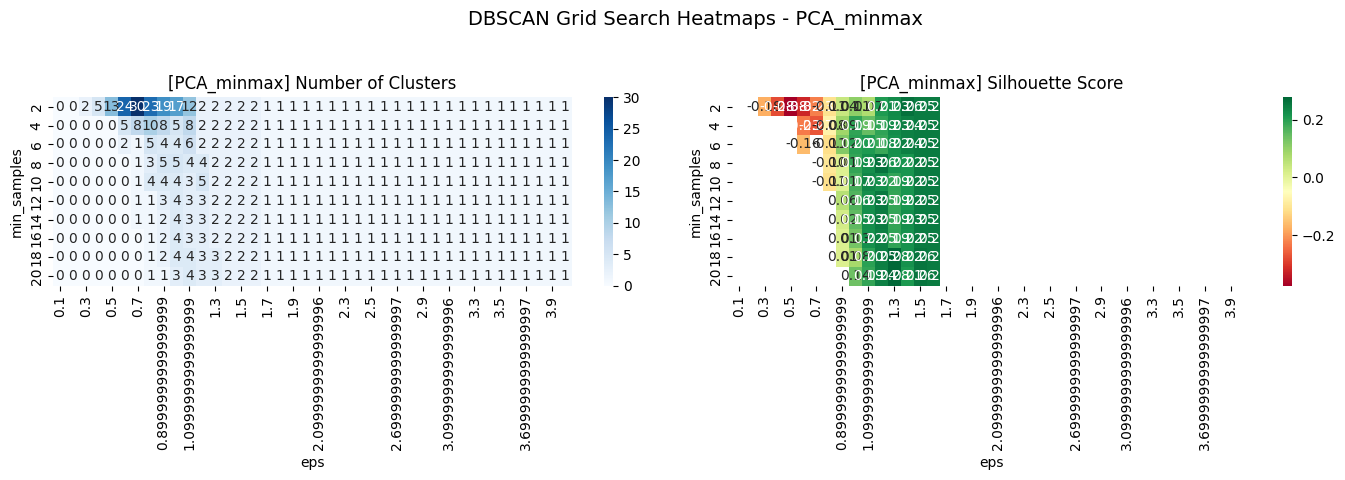

[PCA_minmax] Best params: eps=1.3, min_samples=18.0, clusters=3.0, silhouette=0.2779


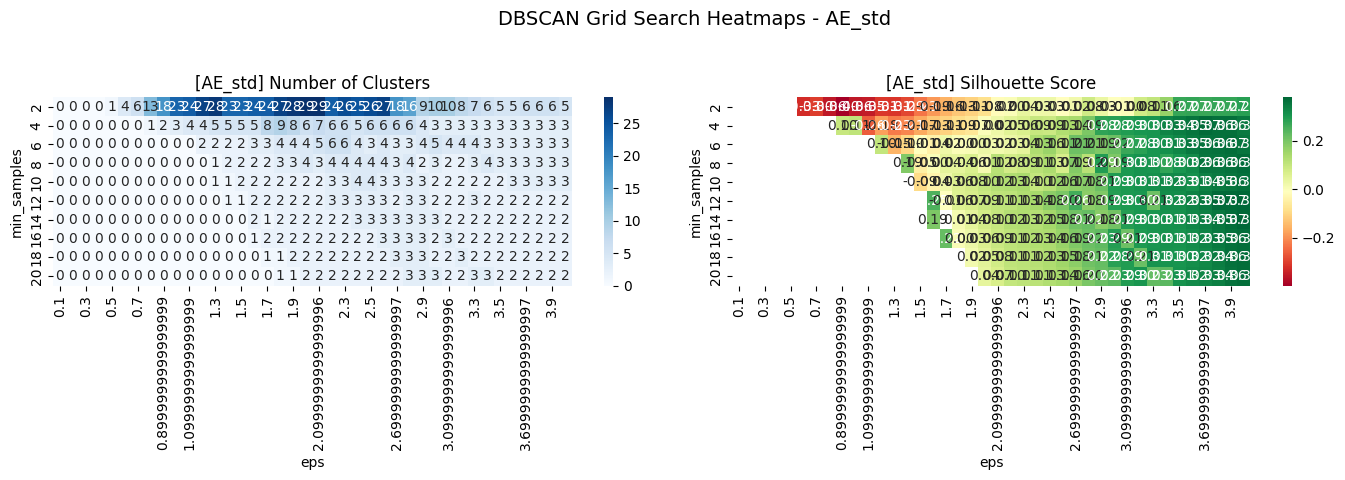

[AE_std] Best params: eps=4.0, min_samples=14.0, clusters=2.0, silhouette=0.3777


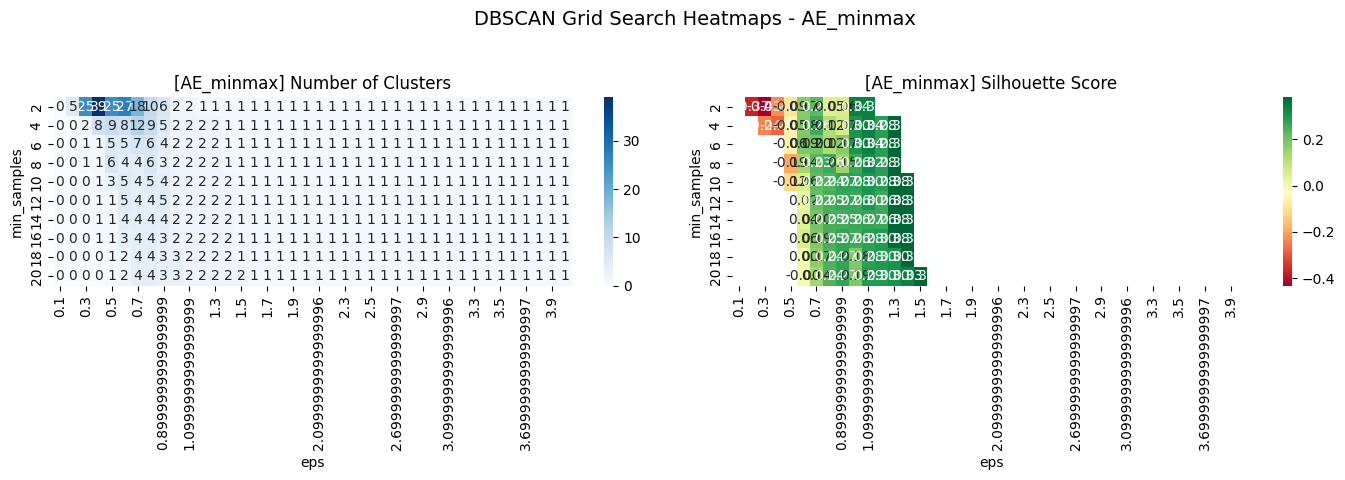

[AE_minmax] Best params: eps=1.3, min_samples=4.0, clusters=2.0, silhouette=0.3811


In [519]:
# ---------- 6. Helper: DBSCAN grid heatmap ----------
def dbscan_heatmap(X, eps_vals, min_samples_vals, dataset_name=""):
    # TODO: implement grid search heatmap for DBSCAN

    """
    High-level outline:
        1. Iterate over every (eps, min_samples) combination.
        2. Fit DBSCAN, record:
            - number of clusters (ignore noise label -1)
            - Silhouette score (set to NaN if clusters < 2)
        3. Pivot the results into two matrices:
            - heatmap of cluster counts
            - heatmap of Silhouette scores
        4. Display the two heatmaps side by side.
        5. After inspecting the visuals, manually choose the
            best (eps, min_samples) pair for your final model.
    """
    # TODO: implement the loop, DataFrame creation, seaborn heatmaps,
    #       and return or log the chosen parameters.

    # 1. Iterate over every (eps, min_samples) combinations.
    results = []
    for eps in eps_vals:
        for min_samples in min_samples_vals:
            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(X)

            # 2-1. number of clusters (ignore noise label -1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            # 2-2. Silhouette score (set to NaN if clusters < 2)
            if n_clusters >= 2:
                score = silhouette_score(X, labels)
            else:
                score = np.nan

            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'silhouette': score
            })

    df = pd.DataFrame(results)

    # 3. Pivot the results into two matrices:
    # 3-1. heatmap of cluster counts
    cluster_mat = df.pivot(index='min_samples', columns='eps', values='n_clusters')
    # 3-2. heatmap of Silhouette scores
    sil_mat = df.pivot(index='min_samples', columns='eps', values='silhouette')

    # 4. Display the two heatmaps side by side.
    # 4. Display the two heatmaps side by side.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    sns.heatmap(cluster_mat, annot=True, fmt='.0f', cmap='Blues', ax=ax1)
    ax1.set_title(f'[{dataset_name}] Number of Clusters')
    ax1.set_xlabel('eps')
    ax1.set_ylabel('min_samples')

    sns.heatmap(sil_mat, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax2)
    ax2.set_title(f'[{dataset_name}] Silhouette Score')
    ax2.set_xlabel('eps')
    ax2.set_ylabel('min_samples')

    fig.suptitle(f'DBSCAN Grid Search Heatmaps - {dataset_name}', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave room for suptitle
    plt.show()

    # 5. After inspecting the visuals, manually choose the best (eps, min_samples) pair for your final model.
    valid_df = df.dropna(subset=['silhouette'])

    if not valid_df.empty:
        best_row = valid_df.loc[valid_df['silhouette'].idxmax()]
        print(f"[{dataset_name}] Best params: eps={best_row['eps']}, min_samples={best_row['min_samples']}, "
            f"clusters={best_row['n_clusters']}, silhouette={best_row['silhouette']:.4f}")
    else:
        print("No valid silhouette scores (all NaN). Try different parameter ranges.")


eps_vals = np.linspace(0.1, 4, 40)
min_samples_vals = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

# X_ae = train_ae(X_std, latent_dim=10, epochs=100, optimizer=optim.Adam, criterion=nn.MSELoss, generator=g)[0]
dbscan_heatmap(X_filled, eps_vals, min_samples_vals, dataset_name="Raw")
dbscan_heatmap(X_pca, eps_vals, min_samples_vals, dataset_name="PCA_std")
dbscan_heatmap(X_pca_minmax, eps_vals, min_samples_vals, dataset_name="PCA_minmax")
dbscan_heatmap(X_ae_std, eps_vals, min_samples_vals, dataset_name="AE_std")
dbscan_heatmap(X_ae_minmax, eps_vals, min_samples_vals, dataset_name="AE_minmax")

In [522]:
# ---------- 7. Final clustering (student-chosen params) ----------
# TODO: run k-Means, Agglomerative, DBSCAN with the parameters you selected
# k-Means
best_k_kmeans = 4
best_k_agg = 6
best_method = 'ward'
eps_val = 1.3
min_samples_val = 4

X_final = X_ae_minmax

# ---------- kMeans ----------
kmeans = KMeans(n_clusters=best_k_kmeans, random_state=42)
labels_km = kmeans.fit_predict(X_final)

# ---------- Agglomerative ----------
agg = AgglomerativeClustering(n_clusters=best_k_agg, linkage=best_method,)
labels_agg = agg.fit_predict(X_final)

# ---------- DBSCAN ----------
db = DBSCAN(eps=eps_val, min_samples=min_samples_val)
labels_db = db.fit_predict(X_final)  # -1: noise

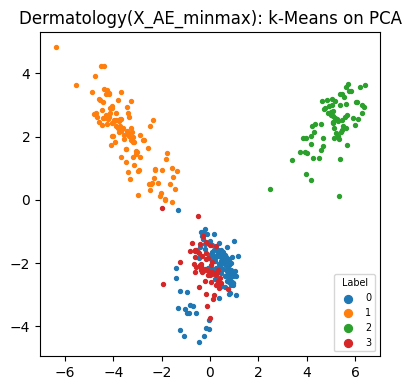

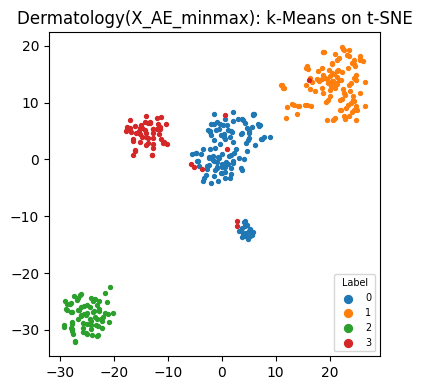

ARI: 0.7764


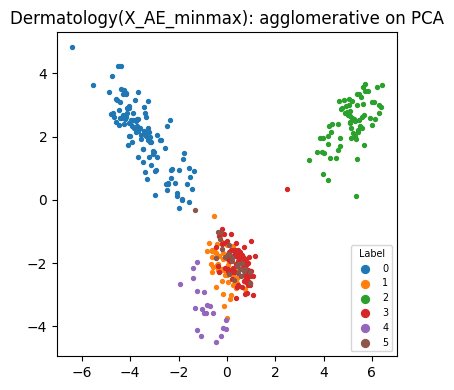

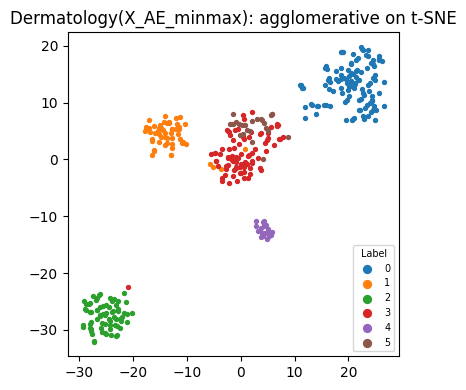

ARI: 0.8607


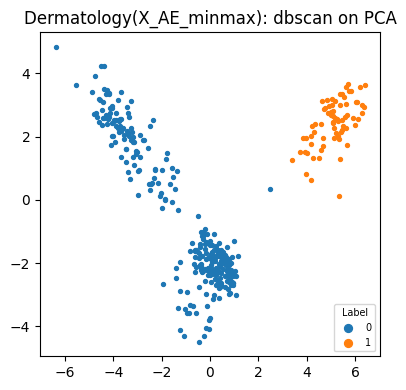

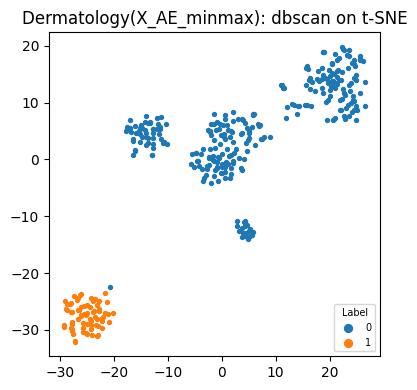

ARI: 0.2004


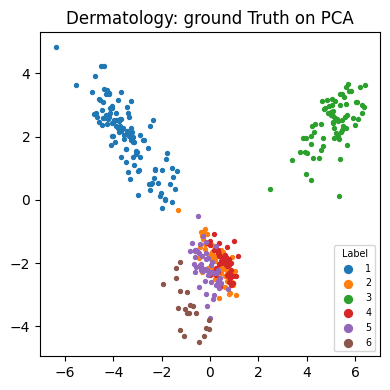

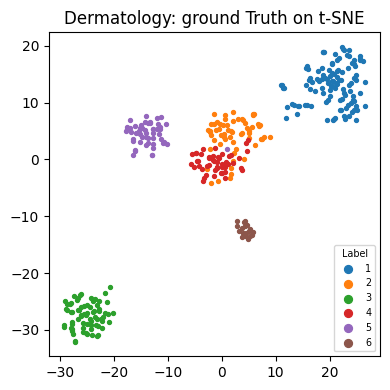

In [523]:
# ---------- 8. Visualisation helper ----------
def scatter_2d(X2, labels, title):
    plt.figure(figsize=(4, 4))
    unique_labels = np.unique(labels)
    for lbl in unique_labels:
        plt.scatter(X2[labels == lbl, 0], X2[labels == lbl, 1], 
                    label=str(lbl), s=8)
        
    plt.title(title)
    plt.legend(title="Label", loc="lower right", fontsize="x-small", title_fontsize="x-small", markerscale=2)
    plt.tight_layout()
    plt.show()

# evaluate clustering result using Adjusted Rand Index(ARI) metric
def evaluate_clustering(y_true, y_pred, name):
    ari = adjusted_rand_score(y_true, y_pred)
    print(f"ARI: {ari:.4f}")

model = TSNE(learning_rate=300, random_state=3)
TSNE_X = model.fit_transform(X_std)

# Example:
# scatter_2d(X_pca, labels_km, "Dermatology: k-Means on PCA")
scatter_2d(X_pca, labels_km, "Dermatology(X_AE_minmax): k-Means on PCA")
scatter_2d(TSNE_X, labels_km, "Dermatology(X_AE_minmax): k-Means on t-SNE")
evaluate_clustering(y_true, labels_km, "K-Means")

scatter_2d(X_pca, labels_agg, "Dermatology(X_AE_minmax): agglomerative on PCA")
scatter_2d(TSNE_X, labels_agg, "Dermatology(X_AE_minmax): agglomerative on t-SNE")
evaluate_clustering(y_true, labels_agg, "K-agglomerative")

scatter_2d(X_pca, labels_db, "Dermatology(X_AE_minmax): dbscan on PCA")
scatter_2d(TSNE_X, labels_db, "Dermatology(X_AE_minmax): dbscan on t-SNE")
evaluate_clustering(y_true, labels_db, "dbscan")

scatter_2d(X_pca, y_true, "Dermatology: ground Truth on PCA")
scatter_2d(TSNE_X, y_true, "Dermatology: ground Truth on t-SNE")

Repeat visualization for Representation Effect.

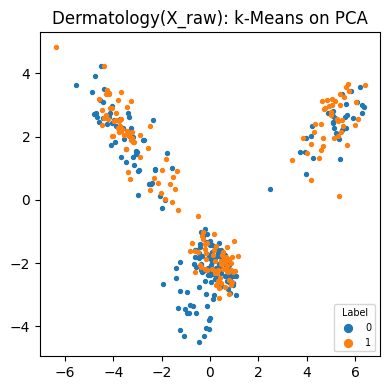

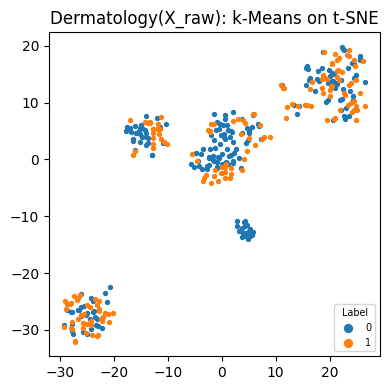

ARI: 0.0053


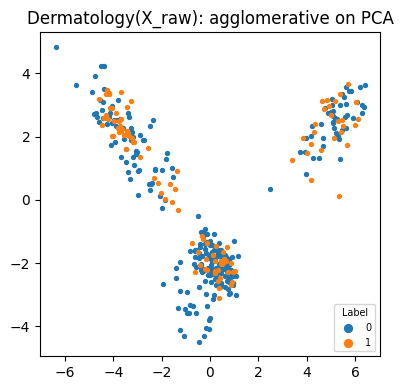

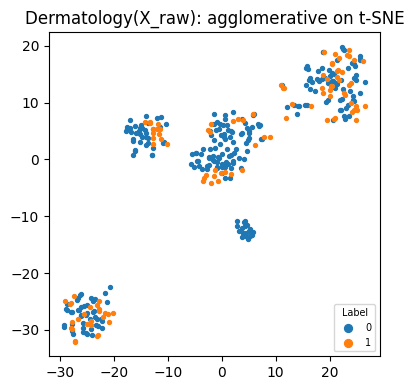

ARI: -0.0124


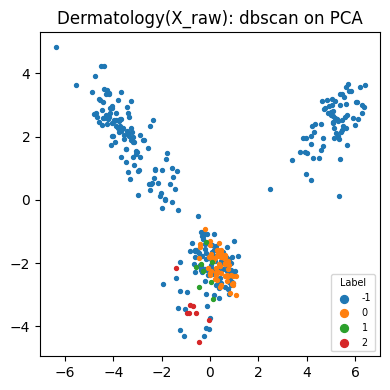

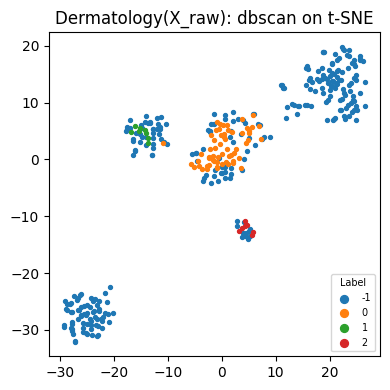

ARI: 0.1287


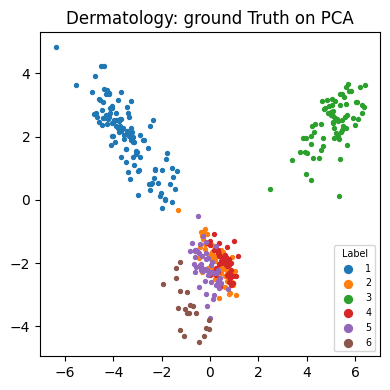

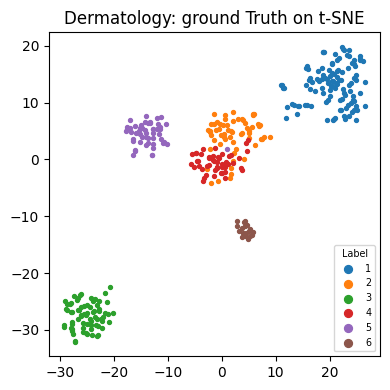

In [524]:
# ---------- 7. Final clustering - raw ----------
# TODO: run k-Means, Agglomerative, DBSCAN with the parameters you selected
# k-Means
best_k_kmeans = 2
best_k_agg = 2
best_method = 'ward'
eps_val = 3.8
min_samples_val = 8

X_final = X_filled

# ---------- kMeans ----------
kmeans = KMeans(n_clusters=best_k_kmeans, random_state=42)
labels_km = kmeans.fit_predict(X_final)

# ---------- Agglomerative ----------
agg = AgglomerativeClustering(n_clusters=best_k_agg, linkage=best_method,)
labels_agg = agg.fit_predict(X_final)

# ---------- DBSCAN ----------
db = DBSCAN(eps=eps_val, min_samples=min_samples_val)
labels_db = db.fit_predict(X_final)  # -1: noise
model = TSNE(learning_rate=300, random_state=3)
TSNE_X = model.fit_transform(X_std)

# Example:
# scatter_2d(X_pca, labels_km, "Dermatology: k-Means on PCA")
scatter_2d(X_pca, labels_km, "Dermatology(X_raw): k-Means on PCA")
scatter_2d(TSNE_X, labels_km, "Dermatology(X_raw): k-Means on t-SNE")
evaluate_clustering(y_true, labels_km, "K-Means")

scatter_2d(X_pca, labels_agg, "Dermatology(X_raw): agglomerative on PCA")
scatter_2d(TSNE_X, labels_agg, "Dermatology(X_raw): agglomerative on t-SNE")
evaluate_clustering(y_true, labels_agg, "K-agglomerative")

scatter_2d(X_pca, labels_db, "Dermatology(X_raw): dbscan on PCA")
scatter_2d(TSNE_X, labels_db, "Dermatology(X_raw): dbscan on t-SNE")
evaluate_clustering(y_true, labels_db, "dbscan")

scatter_2d(X_pca, y_true, "Dermatology: ground Truth on PCA")
scatter_2d(TSNE_X, y_true, "Dermatology: ground Truth on t-SNE")

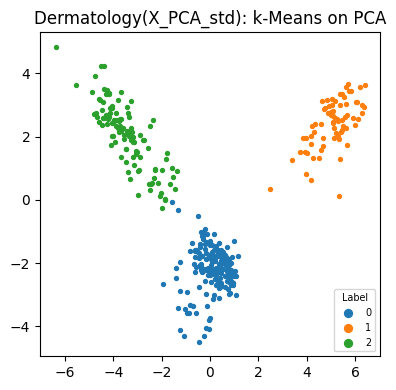

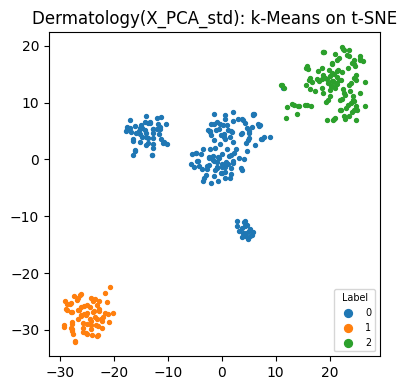

ARI: 0.5709


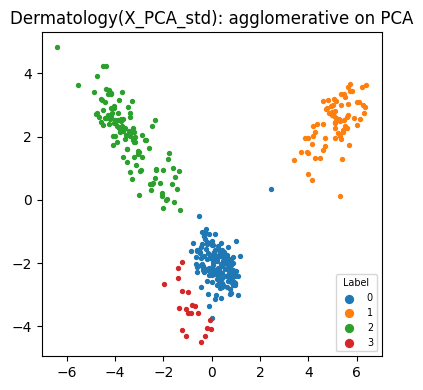

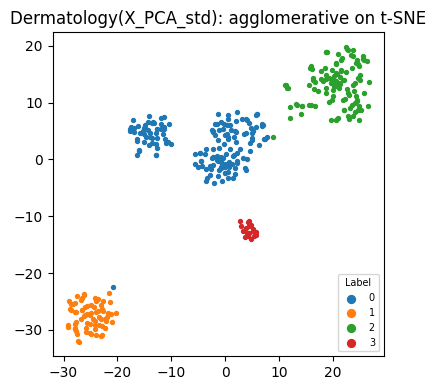

ARI: 0.6607


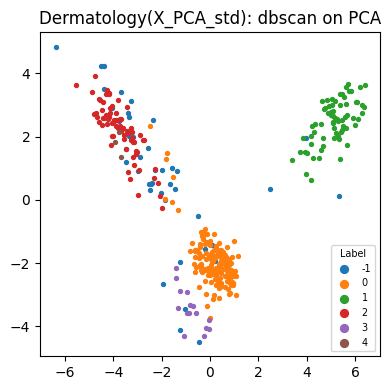

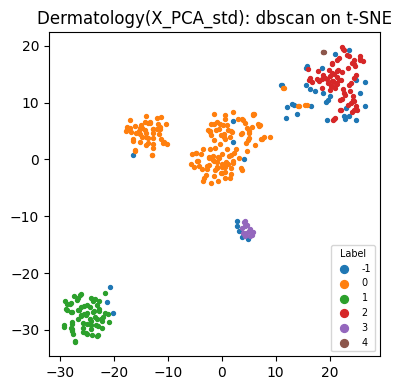

ARI: 0.4663


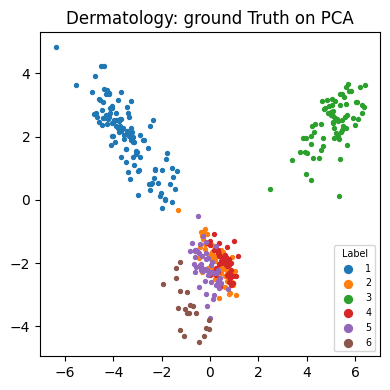

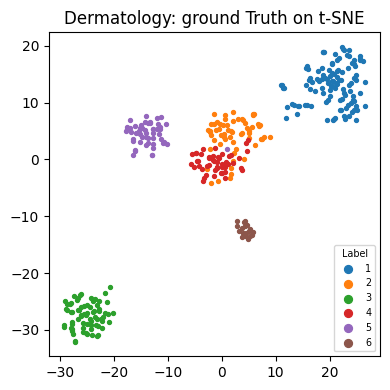

In [525]:
# ---------- 7. Final clustering - PCA_std ----------
# TODO: run k-Means, Agglomerative, DBSCAN with the parameters you selected
# k-Means
best_k_kmeans = 3
best_k_agg = 4
best_method = 'ward'
eps_val = 4.0
min_samples_val = 2

X_final = X_pca

# ---------- kMeans ----------
kmeans = KMeans(n_clusters=best_k_kmeans, random_state=42)
labels_km = kmeans.fit_predict(X_final)

# ---------- Agglomerative ----------
agg = AgglomerativeClustering(n_clusters=best_k_agg, linkage=best_method,)
labels_agg = agg.fit_predict(X_final)

# ---------- DBSCAN ----------
db = DBSCAN(eps=eps_val, min_samples=min_samples_val)
labels_db = db.fit_predict(X_final)  # -1: noise
model = TSNE(learning_rate=300, random_state=3)
TSNE_X = model.fit_transform(X_std)

# Example:
# scatter_2d(X_pca, labels_km, "Dermatology: k-Means on PCA")
scatter_2d(X_pca, labels_km, "Dermatology(X_PCA_std): k-Means on PCA")
scatter_2d(TSNE_X, labels_km, "Dermatology(X_PCA_std): k-Means on t-SNE")
evaluate_clustering(y_true, labels_km, "K-Means")

scatter_2d(X_pca, labels_agg, "Dermatology(X_PCA_std): agglomerative on PCA")
scatter_2d(TSNE_X, labels_agg, "Dermatology(X_PCA_std): agglomerative on t-SNE")
evaluate_clustering(y_true, labels_agg, "K-agglomerative")

scatter_2d(X_pca, labels_db, "Dermatology(X_PCA_std): dbscan on PCA")
scatter_2d(TSNE_X, labels_db, "Dermatology(X_PCA_std): dbscan on t-SNE")
evaluate_clustering(y_true, labels_db, "dbscan")

scatter_2d(X_pca, y_true, "Dermatology: ground Truth on PCA")
scatter_2d(TSNE_X, y_true, "Dermatology: ground Truth on t-SNE")

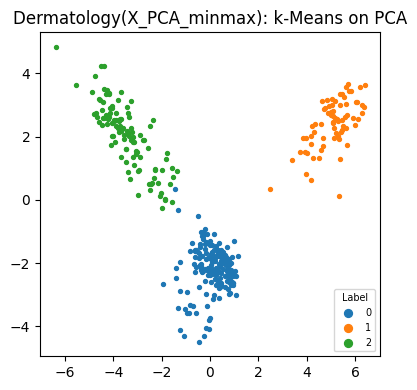

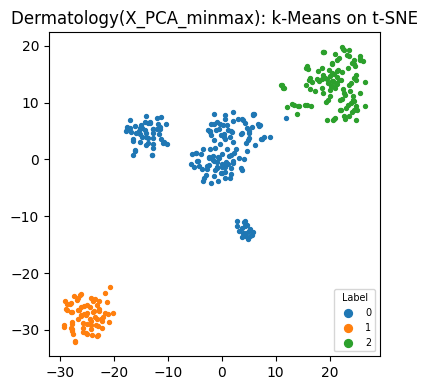

ARI: 0.5709


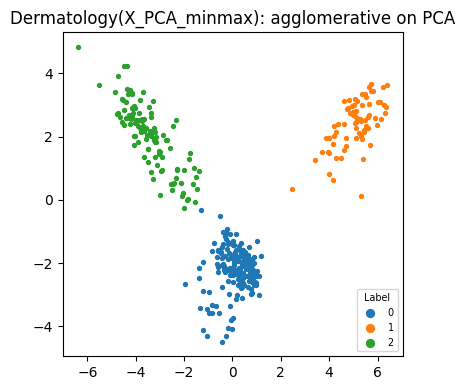

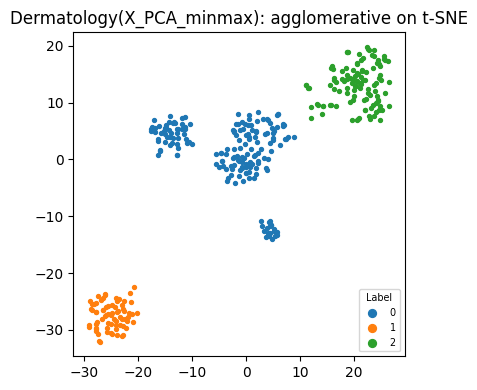

ARI: 0.5806


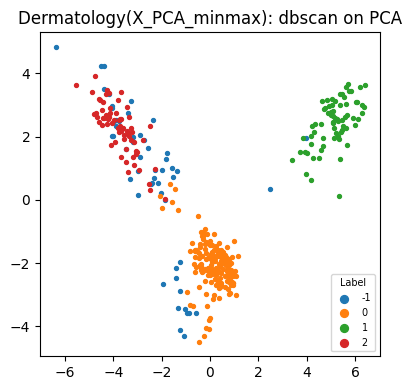

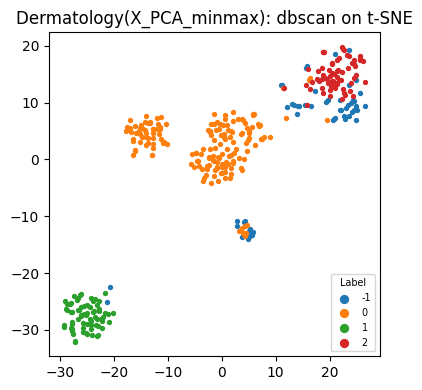

ARI: 0.4296


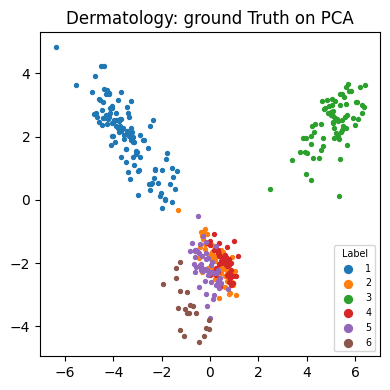

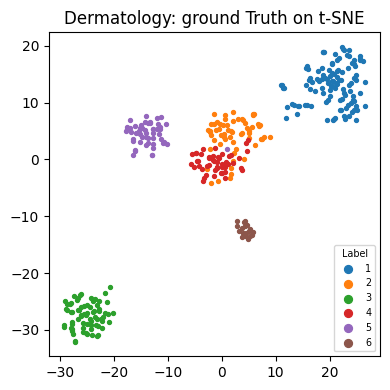

In [526]:
# ---------- 7. Final clustering - PCA_minmax ----------
# TODO: run k-Means, Agglomerative, DBSCAN with the parameters you selected
# k-Means
best_k_kmeans = 3
best_k_agg = 3
best_method = 'ward'
eps_val = 1.3
min_samples_val = 18

X_final = X_pca_minmax

# ---------- kMeans ----------
kmeans = KMeans(n_clusters=best_k_kmeans, random_state=42)
labels_km = kmeans.fit_predict(X_final)

# ---------- Agglomerative ----------
agg = AgglomerativeClustering(n_clusters=best_k_agg, linkage=best_method,)
labels_agg = agg.fit_predict(X_final)

# ---------- DBSCAN ----------
db = DBSCAN(eps=eps_val, min_samples=min_samples_val)
labels_db = db.fit_predict(X_final)  # -1: noise
model = TSNE(learning_rate=300, random_state=3)
TSNE_X = model.fit_transform(X_std)

# Example:
# scatter_2d(X_pca, labels_km, "Dermatology: k-Means on PCA")
scatter_2d(X_pca, labels_km, "Dermatology(X_PCA_minmax): k-Means on PCA")
scatter_2d(TSNE_X, labels_km, "Dermatology(X_PCA_minmax): k-Means on t-SNE")
evaluate_clustering(y_true, labels_km, "K-Means")

scatter_2d(X_pca, labels_agg, "Dermatology(X_PCA_minmax): agglomerative on PCA")
scatter_2d(TSNE_X, labels_agg, "Dermatology(X_PCA_minmax): agglomerative on t-SNE")
evaluate_clustering(y_true, labels_agg, "K-agglomerative")

scatter_2d(X_pca, labels_db, "Dermatology(X_PCA_minmax): dbscan on PCA")
scatter_2d(TSNE_X, labels_db, "Dermatology(X_PCA_minmax): dbscan on t-SNE")
evaluate_clustering(y_true, labels_db, "dbscan")

scatter_2d(X_pca, y_true, "Dermatology: ground Truth on PCA")
scatter_2d(TSNE_X, y_true, "Dermatology: ground Truth on t-SNE")

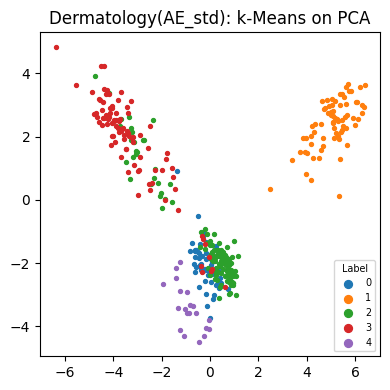

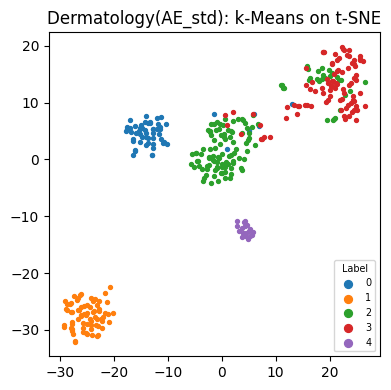

ARI: 0.5948


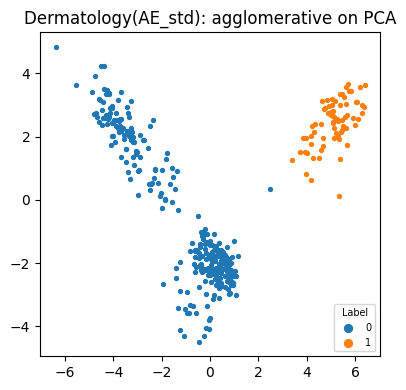

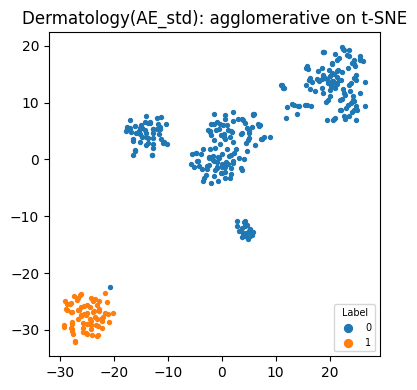

ARI: 0.2004


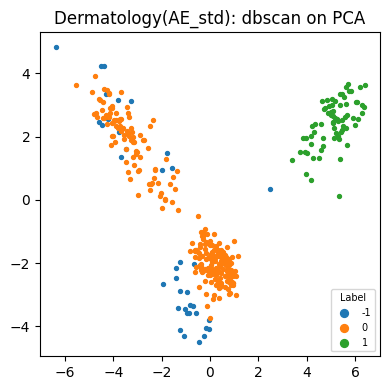

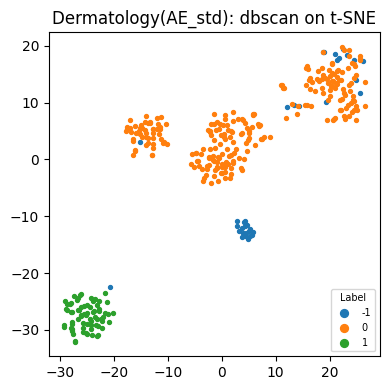

ARI: 0.2556


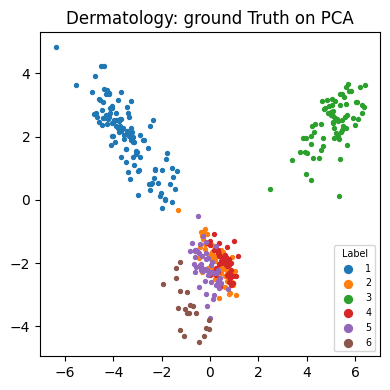

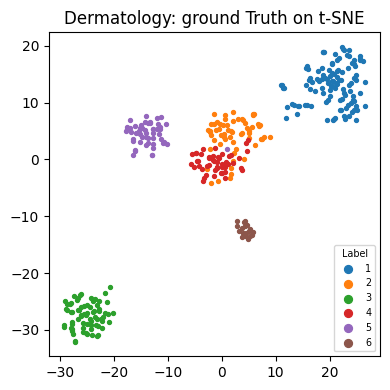

In [527]:
# ---------- 7. Final clustering - AE_std ----------
# TODO: run k-Means, Agglomerative, DBSCAN with the parameters you selected
# k-Means
best_k_kmeans = 5
best_k_agg = 2
best_method = 'ward'
eps_val = 4.0
min_samples_val = 14

X_final = X_ae_std

# ---------- kMeans ----------
kmeans = KMeans(n_clusters=best_k_kmeans, random_state=42)
labels_km = kmeans.fit_predict(X_final)

# ---------- Agglomerative ----------
agg = AgglomerativeClustering(n_clusters=best_k_agg, linkage=best_method,)
labels_agg = agg.fit_predict(X_final)

# ---------- DBSCAN ----------
db = DBSCAN(eps=eps_val, min_samples=min_samples_val)
labels_db = db.fit_predict(X_final)  # -1: noise
model = TSNE(learning_rate=300, random_state=3)
TSNE_X = model.fit_transform(X_std)

# Example:
# scatter_2d(X_pca, labels_km, "Dermatology: k-Means on PCA")
scatter_2d(X_pca, labels_km, "Dermatology(AE_std): k-Means on PCA")
scatter_2d(TSNE_X, labels_km, "Dermatology(AE_std): k-Means on t-SNE")
evaluate_clustering(y_true, labels_km, "K-Means")

scatter_2d(X_pca, labels_agg, "Dermatology(AE_std): agglomerative on PCA")
scatter_2d(TSNE_X, labels_agg, "Dermatology(AE_std): agglomerative on t-SNE")
evaluate_clustering(y_true, labels_agg, "K-agglomerative")

scatter_2d(X_pca, labels_db, "Dermatology(AE_std): dbscan on PCA")
scatter_2d(TSNE_X, labels_db, "Dermatology(AE_std): dbscan on t-SNE")
evaluate_clustering(y_true, labels_db, "dbscan")

scatter_2d(X_pca, y_true, "Dermatology: ground Truth on PCA")
scatter_2d(TSNE_X, y_true, "Dermatology: ground Truth on t-SNE")

In [528]:
# ---------- 9. UNKNOWN DATASET ----------
# Repeat steps 4–8 for X_unknown (skip AE training).
from sklearn.metrics import calinski_harabasz_score


[np.float64(0.24000896656523873), np.float64(0.3164126809307609), np.float64(0.35904048733224214), np.float64(0.3695798246031198), np.float64(0.32524201053274787), np.float64(0.2934497894522426), np.float64(0.2802217149420235), np.float64(0.2872008458051882), np.float64(0.2926598949678288), np.float64(0.30016523061304934), np.float64(0.3043305609851219), np.float64(0.2799921659158152), np.float64(0.27532375492349953), np.float64(0.2528548503251068)]


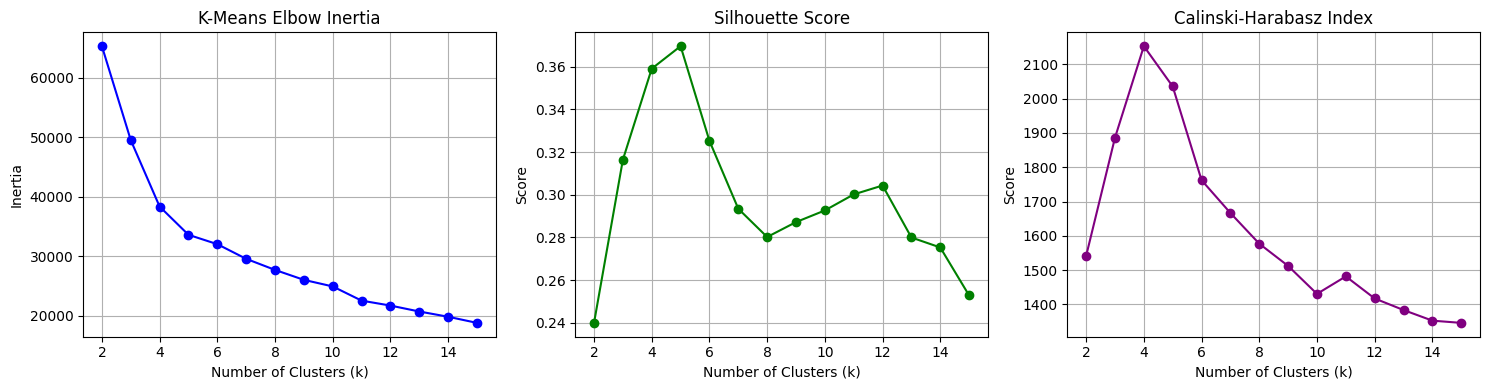

In [529]:
# ---------- 4. Helper: k-Means Elbow, Silhouette, Calinski-Harabasz ----------
def kmeans_metrics_calculator(X, k_range=range(2, 16)):
    inertia, silhouette, calinski = [], [], []
    
    for k in k_range:
        model = KMeans(n_clusters=k, random_state=46)
        labels = model.fit_predict(X)
        
        inertia.append(model.inertia_)
        silhouette.append(silhouette_score(X, labels))
        calinski.append(calinski_harabasz_score(X, labels))
    
    return inertia, silhouette, calinski

# Actual computation
k_range = range(2, 16)
inertia, sil, ch = kmeans_metrics_calculator(X_unknown, k_range)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Elbow Plot
ax1.plot(k_range, inertia, marker='o', color='blue')
ax1.set_title("K-Means Elbow Inertia")
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia")
ax1.grid(True)

# Silhouette Plot
print(sil)
ax2.plot(k_range, sil, marker='o', color='green')
ax2.set_title("Silhouette Score")
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Score")
ax2.grid(True)

# Calinski-Harabasz Plot
ax3.plot(k_range, ch, marker='o', color='purple')
ax3.set_title("Calinski-Harabasz Index")
ax3.set_xlabel("Number of Clusters (k)")
ax3.set_ylabel("Score")
ax3.grid(True)

plt.tight_layout()
plt.show()

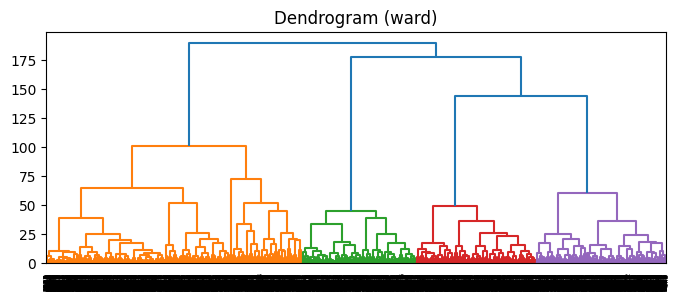

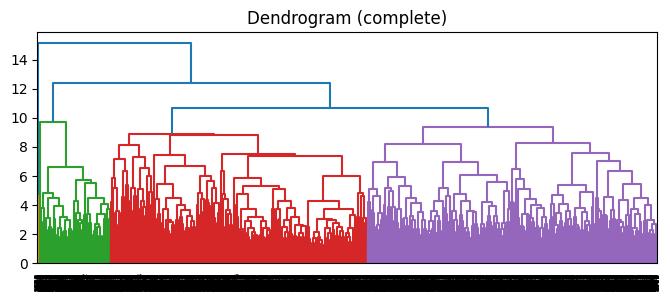

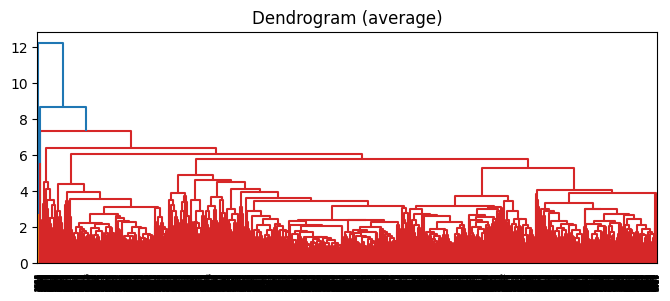

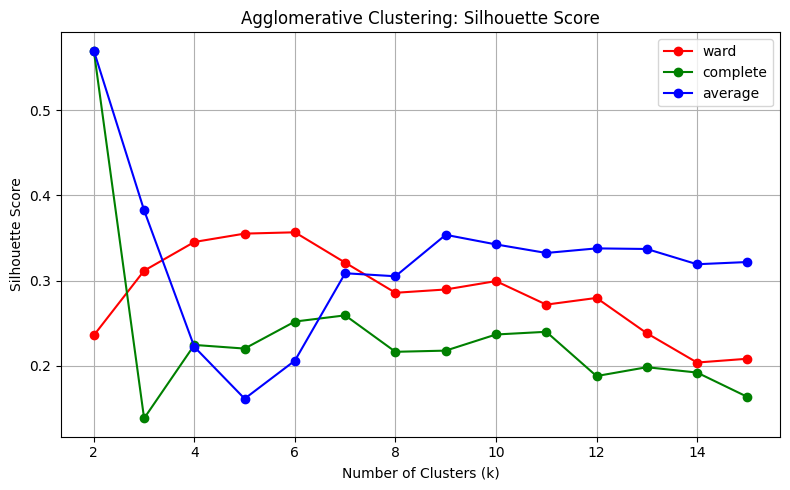

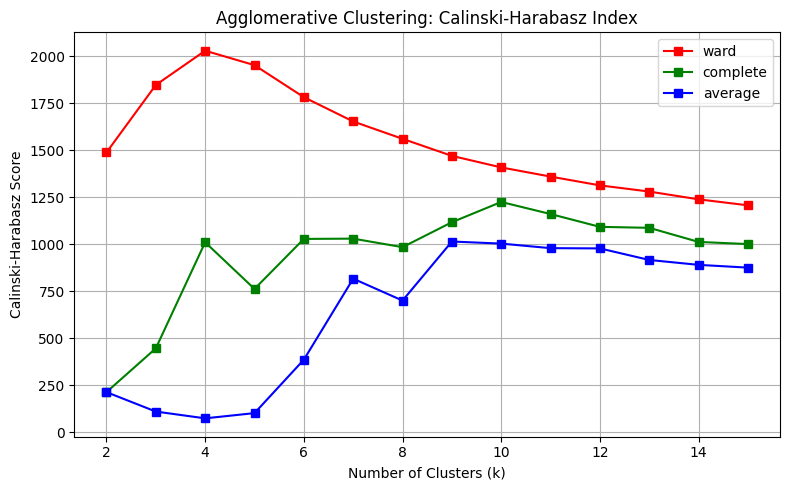

In [530]:
# ---------- 5. Helper: Agglomerative Dendrogram ----------
def dendro_plot(X, method):  # Draw dendrogram for each linkage method
    Z = linkage(X, method=method)
    plt.figure(figsize=(8, 3))
    dendrogram(Z)
    plt.title(f"Dendrogram ({method})")
    plt.show()

def agglo_metrics_calculator(X, method, k_range=range(2, 16)):
    sil, ch = [], []
    for k in k_range:
        model = AgglomerativeClustering(n_clusters=k, linkage=method)
        labels = model.fit_predict(X)
        sil.append(silhouette_score(X, labels))
        ch.append(calinski_harabasz_score(X, labels))
    return sil, ch

methods = ['ward', 'complete', 'average']
colors = ['r', 'g', 'b']
k_range = range(2, 16)
X = X_unknown

# Plot dendrograms
for method in methods:
    dendro_plot(X, method)

# Compute silhouette and CHI scores
silhouette_dict = {}
ch_dict = {}
for method in methods:
    sil, ch = agglo_metrics_calculator(X, method, k_range)
    silhouette_dict[method] = sil
    ch_dict[method] = ch

# Plot silhouette scores
plt.figure(figsize=(8, 5))
for method, color in zip(methods, colors):
    plt.plot(k_range, silhouette_dict[method], marker='o', label=f"{method}", color=color)
plt.title("Agglomerative Clustering: Silhouette Score")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Calinski-Harabasz scores
plt.figure(figsize=(8, 5))
for method, color in zip(methods, colors):
    plt.plot(k_range, ch_dict[method], marker='s', label=f"{method}", color=color)
plt.title("Agglomerative Clustering: Calinski-Harabasz Index")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


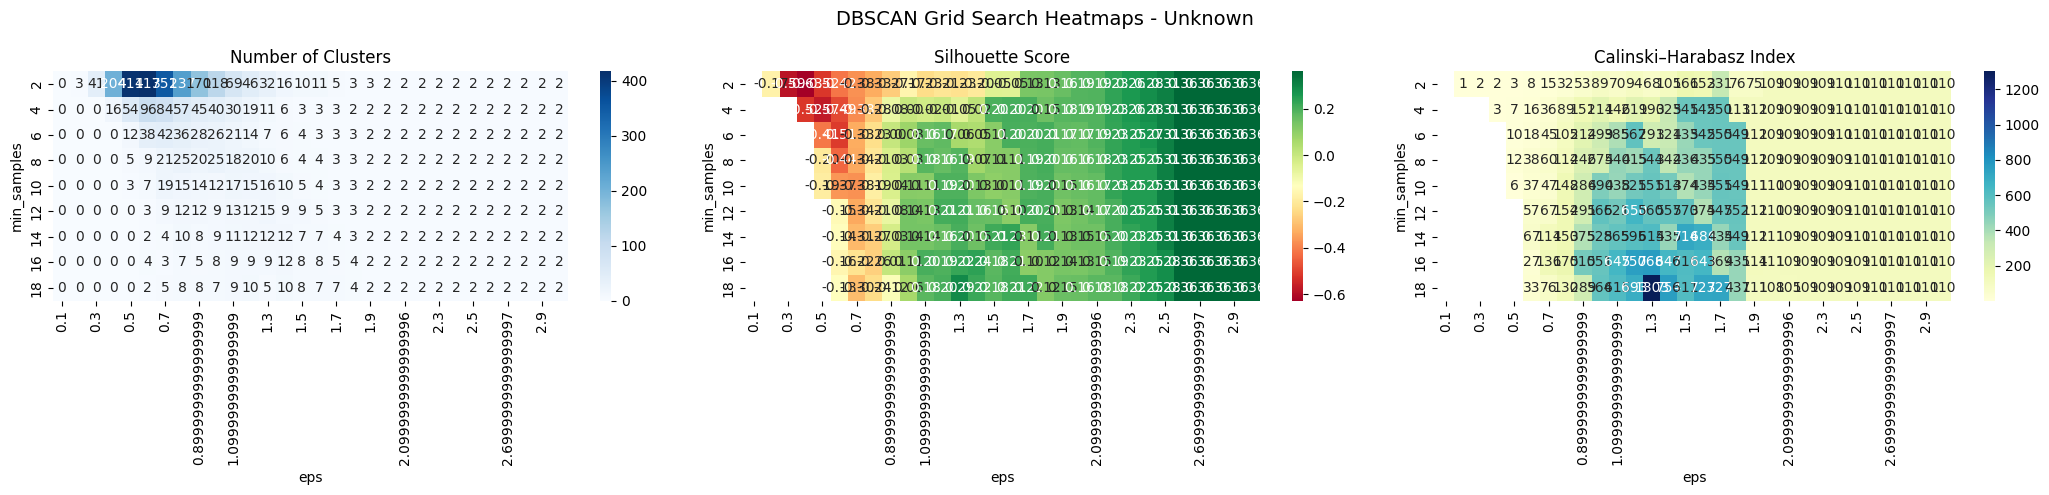

[Unknown] Best params by Silhouette: eps=2.6, min_samples=2.0, clusters=2.0, silhouette=0.3612, calinski=109.96


In [532]:
def dbscan_heatmap_with_ch(X, eps_vals, min_samples_vals, dataset_name=""):
    results = []
    for eps in eps_vals:
        for min_samples in min_samples_vals:
            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(X)

            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters >= 2:
                sil_score = silhouette_score(X, labels)
                ch_score = calinski_harabasz_score(X, labels)
            else:
                sil_score = np.nan
                ch_score = np.nan

            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'silhouette': sil_score,
                'calinski': ch_score
            })

    df = pd.DataFrame(results)

    cluster_mat = df.pivot(index='min_samples', columns='eps', values='n_clusters')
    sil_mat = df.pivot(index='min_samples', columns='eps', values='silhouette')
    ch_mat = df.pivot(index='min_samples', columns='eps', values='calinski')

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5))

    sns.heatmap(cluster_mat, annot=True, fmt='.0f', cmap='Blues', ax=ax1)
    ax1.set_title('Number of Clusters')
    ax1.set_xlabel('eps')
    ax1.set_ylabel('min_samples')

    sns.heatmap(sil_mat, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax2)
    ax2.set_title('Silhouette Score')
    ax2.set_xlabel('eps')
    ax2.set_ylabel('min_samples')

    sns.heatmap(ch_mat, annot=True, fmt='.0f', cmap='YlGnBu', ax=ax3)
    ax3.set_title('Calinski–Harabasz Index')
    ax3.set_xlabel('eps')
    ax3.set_ylabel('min_samples')

    fig.suptitle(f'DBSCAN Grid Search Heatmaps - {dataset_name}', fontsize=14)
    plt.tight_layout()
    plt.show()

    valid_df = df.dropna(subset=['silhouette', 'calinski'])

    if not valid_df.empty:
        best_row = valid_df.loc[valid_df['silhouette'].idxmax()]
        print(f"[{dataset_name}] Best params by Silhouette: eps={best_row['eps']}, min_samples={best_row['min_samples']}, "
              f"clusters={best_row['n_clusters']}, silhouette={best_row['silhouette']:.4f}, calinski={best_row['calinski']:.2f}")
    else:
        print(f"[{dataset_name}] No valid silhouette or calinski scores. Try different parameter ranges.")

eps_vals = np.linspace(0.1, 3, 30)
min_samples_vals = range(2, 20, 2)

dbscan_heatmap_with_ch(X_unknown, eps_vals, min_samples_vals, dataset_name="Unknown")


In [545]:
# ---------- 7. Final clustering (student-chosen params) ----------
# TODO: run k-Means, Agglomerative, DBSCAN with the parameters you selected
# k-Means
best_k_kmeans = 4
best_k_agg = 6
best_method = 'ward'
eps_val = 5.0
min_samples_val = 2

# ---------- kMeans ----------
kmeans = KMeans(n_clusters=best_k_kmeans, random_state=42)
labels_km = kmeans.fit_predict(X_unknown)

# ---------- Agglomerative ----------
agg = AgglomerativeClustering(n_clusters=best_k_agg, linkage=best_method)
labels_agg = agg.fit_predict(X_unknown)

# ---------- DBSCAN ----------
db = DBSCAN(eps=eps_val, min_samples=min_samples_val)
labels_db = db.fit_predict(X_unknown)  # -1: noise

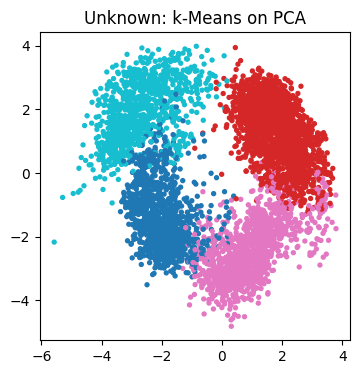

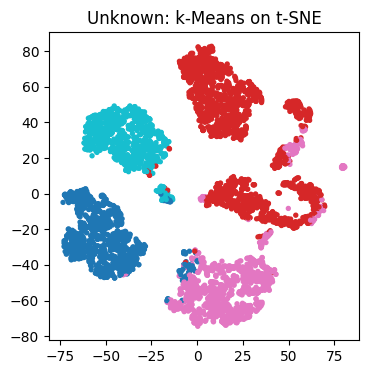

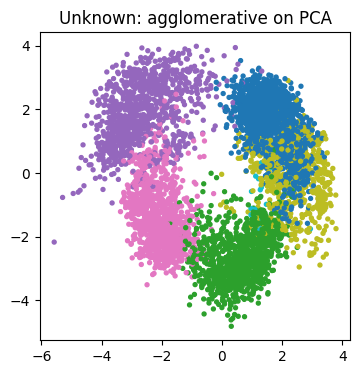

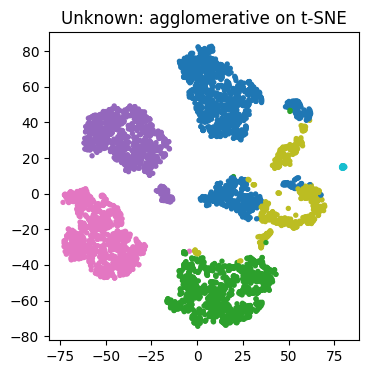

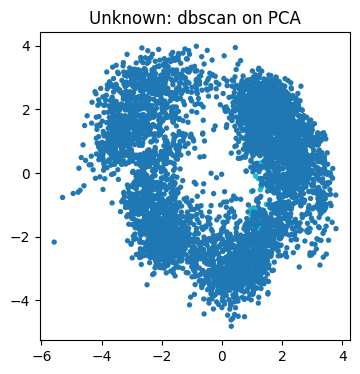

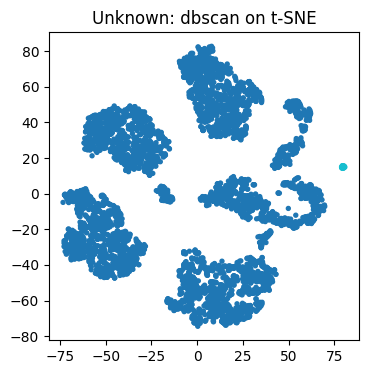

In [546]:
# ---------- 8. Visualisation helper ----------
def scatter_2d(X2, labels, title):
    plt.figure(figsize=(4, 4))
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap="tab10", s=8)
    plt.title(title)
    plt.show()

model = TSNE(learning_rate=300, random_state=3)
TSNE_X = model.fit_transform(X_unknown)

# Example:
# scatter_2d(X_pca, labels_km, "Dermatology: k-Means on PCA")
scatter_2d(X_unknown, labels_km, "Unknown: k-Means on PCA")
scatter_2d(TSNE_X, labels_km, "Unknown: k-Means on t-SNE")

scatter_2d(X_unknown, labels_agg, "Unknown: agglomerative on PCA")
scatter_2d(TSNE_X, labels_agg, "Unknown: agglomerative on t-SNE")

scatter_2d(X_unknown, labels_db, "Unknown: dbscan on PCA")
scatter_2d(TSNE_X, labels_db, "Unknown: dbscan on t-SNE")

In [547]:
# ---------- 7. Final clustering (student-chosen params, applying Calinski-Harabasz) ----------
# TODO: run k-Means, Agglomerative, DBSCAN with the parameters you selected
# k-Means
best_k_kmeans = 4
best_k_agg = 10
best_method = 'complete'
eps_val = 1.3
min_samples_val = 18

# ---------- kMeans ----------
kmeans = KMeans(n_clusters=best_k_kmeans, random_state=42)
labels_km = kmeans.fit_predict(X_unknown)

# ---------- Agglomerative ----------
agg = AgglomerativeClustering(n_clusters=best_k_agg, linkage=best_method)
labels_agg = agg.fit_predict(X_unknown)

# ---------- DBSCAN ----------
db = DBSCAN(eps=eps_val, min_samples=min_samples_val)
labels_db = db.fit_predict(X_unknown)  # -1: noise

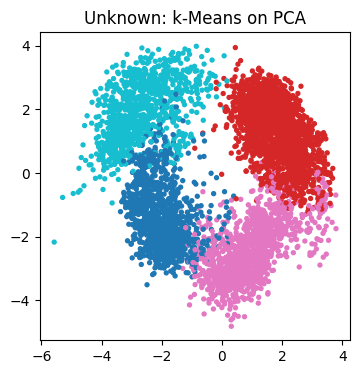

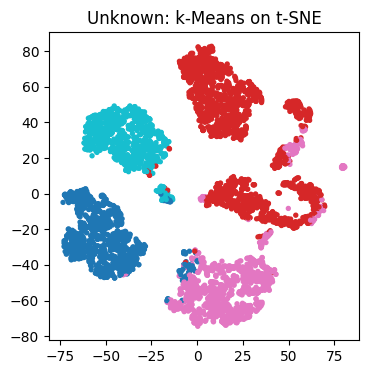

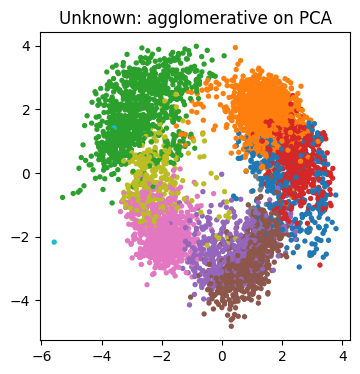

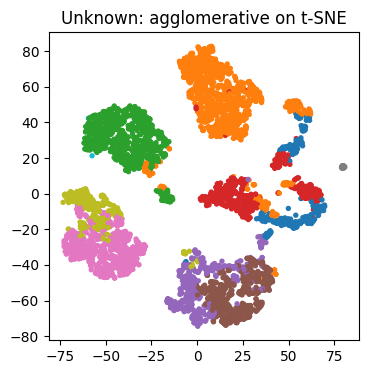

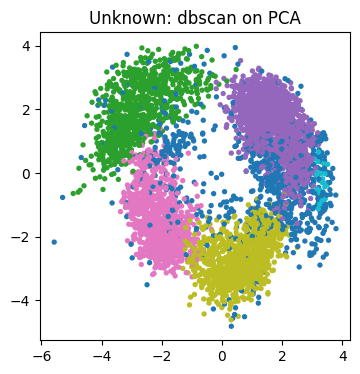

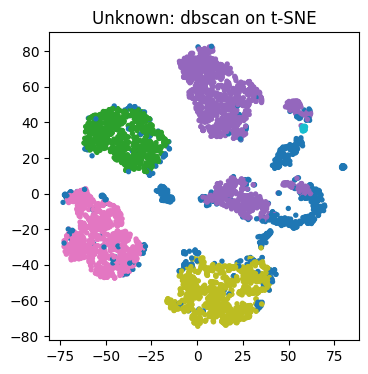

In [548]:
# ---------- 8. Visualisation helper ----------
def scatter_2d(X2, labels, title):
    plt.figure(figsize=(4, 4))
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap="tab10", s=8)
    plt.title(title)
    plt.show()

model = TSNE(learning_rate=300, random_state=3)
TSNE_X = model.fit_transform(X_unknown)

# Example:
# scatter_2d(X_pca, labels_km, "Dermatology: k-Means on PCA")
scatter_2d(X_unknown, labels_km, "Unknown: k-Means on PCA")
scatter_2d(TSNE_X, labels_km, "Unknown: k-Means on t-SNE")

scatter_2d(X_unknown, labels_agg, "Unknown: agglomerative on PCA")
scatter_2d(TSNE_X, labels_agg, "Unknown: agglomerative on t-SNE")

scatter_2d(X_unknown, labels_db, "Unknown: dbscan on PCA")
scatter_2d(TSNE_X, labels_db, "Unknown: dbscan on t-SNE")